## Load data

In [1]:
!wget http://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/project/final_project.zip
!unzip final_project.zip

--2022-12-17 04:16:42--  http://www.cs.toronto.edu/~rgrosse/courses/csc311_f20/project/final_project.zip
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 444833 (434K) [application/zip]
Saving to: ‘final_project.zip.1’

final_project.zip.1 100%[===================>] 434,41K  --.-KB/s    in 0,1s    

2022-12-17 04:16:42 (3,04 MB/s) - ‘final_project.zip.1’ saved [444833/444833]

Archive:  final_project.zip
replace starter_code/majority_vote.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [1]:
import sys
sys.path.append('starter_code/')

In [2]:
from utils import *

In [3]:
train_data = load_train_csv("starter_code/data")
valid_data = load_valid_csv("starter_code/data")
test_data = load_public_test_csv("starter_code/data")

In [4]:
type(train_data)

dict

In [5]:
train_data.keys()

dict_keys(['user_id', 'question_id', 'is_correct'])

In [6]:
len(set(train_data["user_id"])), min(set(train_data["user_id"])), max(set(train_data["user_id"]))

(542, 0, 541)

In [7]:
train_matrix = load_train_sparse("starter_code/data")
train_matrix.shape, (train_matrix.shape[0]*train_matrix.shape[0]/2 - train_matrix.shape[0]/2)

((542, 1774), 146611.0)

## Import

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def to_vector(dist):
    m = len(dist)
    vector_dist = np.zeros(int(m*m/2-m/2))

    for i in range(m):
        for j in range(i+1,m):
            vector_dist[m * i + j - ((i + 2) * (i + 1)) // 2] = dist[i][j]
    return vector_dist

## Clustering

In [10]:
SEED = 42

### Hierarchical

In [16]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.model_selection import ParameterSampler
from scipy.spatial.distance import cosine
import time


def get_linkage(dist_file_name, method, metric):
    if type(dist_file_name) == str:
        dist_matrix = pd.read_csv(dist_file_name)
        vector_dist = to_vector(dist_matrix.values)
    else:
        vector_dist = dist_file_name.copy()
    if method=='centroid':
        linkage_matrix = linkage(vector_dist, method=method, metric="euclidean")    
    else:
        linkage_matrix = linkage(vector_dist, method=method, metric=metric)
    return linkage_matrix

In [12]:
def evaluate_MV_cluster_id(train_matrix, valid_data, cluster_id):
    clusters_df = pd.DataFrame(train_matrix.toarray(), index = cluster_id)
    filled_matrix = clusters_df.copy()
    for i in clusters_df.index.unique():
        filled_matrix.loc[i] = clusters_df.loc[i].fillna(clusters_df.loc[i].mean(axis = 0))
    return sparse_matrix_evaluate(valid_data, filled_matrix.values, threshold=0.5)

Although I came up with fancy algorithm including graph structure (see *Final_project-graph-distance.ipynb* notebook). There is one more option how to deal with NaN-values: set -1 for incorrect answer, 1 for correct, and 0 if the question was not answered at all. 

P.S. spoiler - this easy NaN-filling will actually appear to be the best performer

In [13]:
df_all = pd.DataFrame(train_matrix.toarray())
df_all[df_all == 0] = -1
df_all = df_all.fillna(0)

linkage_matrix = get_linkage("meta-data/cosine_dist_matrix_5.csv", "complete", "euclidian")

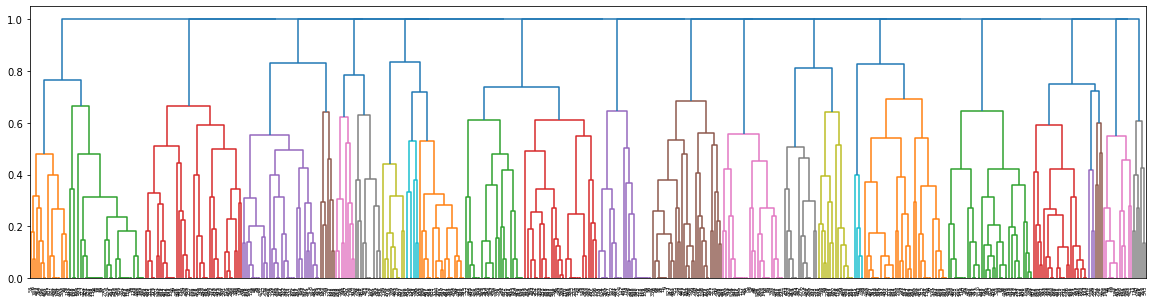

In [14]:
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
dendrogram(linkage_matrix)
plt.show()

In [19]:
K = range(1,11,1)

df_all = pd.DataFrame(train_matrix.toarray())
df_all[df_all == 0] = -1
df_all = df_all.fillna(0)

param_grid_h = {'dist_matrix': [f"meta-data/cosine_dist_matrix_{i}.csv" for i in range(0,6)] + [f"meta-data/dist_matrix_{i}.csv" for i in range(0,6)] + [df_all], 
                'method': ["centroid", "weighted", "average", "complete"],
                'K': K, 
                "metric": ["euclidean", cosine]}

acc_h = []
cl_ids_h = []
params_h = ParameterSampler(param_grid_h, n_iter = 400, random_state=SEED)
for i,params in enumerate(params_h):
    s = time.time()
    
    linkage_matrix = get_linkage(params["dist_matrix"], params["method"], params["metric"])
    cluster_id = fcluster(linkage_matrix, params["K"], criterion="maxclust")    
    
    acc_h.append(evaluate_MV_cluster_id(train_matrix, valid_data, cluster_id))
    cl_ids_h.append(cluster_id)
    print(i, "iteration completed. Accuracy:", acc_h[-1], "Time(min):", (time.time() - s)/60)

0 iteration completed. Accuracy: 0.627293254304262 Time(min): 0.00922302802403768
1 iteration completed. Accuracy: 0.600197572678521 Time(min): 0.038034419218699135
2 iteration completed. Accuracy: 0.6240474174428451 Time(min): 0.006853822867075602
3 iteration completed. Accuracy: 0.6239062941010444 Time(min): 0.008588751157124838
4 iteration completed. Accuracy: 0.5874964719164549 Time(min): 0.03167996009190877
5 iteration completed. Accuracy: 0.5934236522720858 Time(min): 0.04296277364095052
6 iteration completed. Accuracy: 0.6243296641264465 Time(min): 0.006698985894521077
7 iteration completed. Accuracy: 0.6239062941010444 Time(min): 0.007293721040089925
8 iteration completed. Accuracy: 0.6279988710132656 Time(min): 0.00820163091023763
9 iteration completed. Accuracy: 0.6233418007338414 Time(min): 0.007202577590942383
10 iteration completed. Accuracy: 0.6219305673158341 Time(min): 0.016351687908172607
11 iteration completed. Accuracy: 0.6305390911656789 Time(min): 0.010578354199727

In [24]:
n_min_cl = [np.unique(c, return_counts=True)[1].min() for c in cl_ids_h]
n_cl = [len(np.unique(c)) for c in cl_ids_h]
temp = pd.DataFrame({"n_min_cl":n_min_cl, "acc_h": acc_h, "n_cl": n_cl})
temp = temp[temp.n_min_cl > 10]
temp = temp[temp.n_cl > 1]
temp.sort_values("acc_h").iloc[-1]

n_min_cl    62.000000
acc_h        0.654953
n_cl         4.000000
Name: 305, dtype: float64

In [30]:
acc_h[305], list(params_h)[305]

(0.6549534292972058,
 {'metric': <function scipy.spatial.distance.cosine(u, v, w=None)>,
  'method': 'weighted',
  'dist_matrix':      0     1     2     3     4     5     6     7     8     9     ...  1764  \
  0     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
  1     0.0  -1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
  2     0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
  3     0.0   0.0  -1.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
  4     0.0   0.0   0.0   0.0  -1.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
  ..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
  537   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  -1.0   0.0  ...   0.0   
  538   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
  539   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   
  540   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  

In [17]:
best_params = {'dist_matrix': df_all, 
                'method': "weighted",
                'K': 4, 
                "metric": cosine}

0.6549534292972058


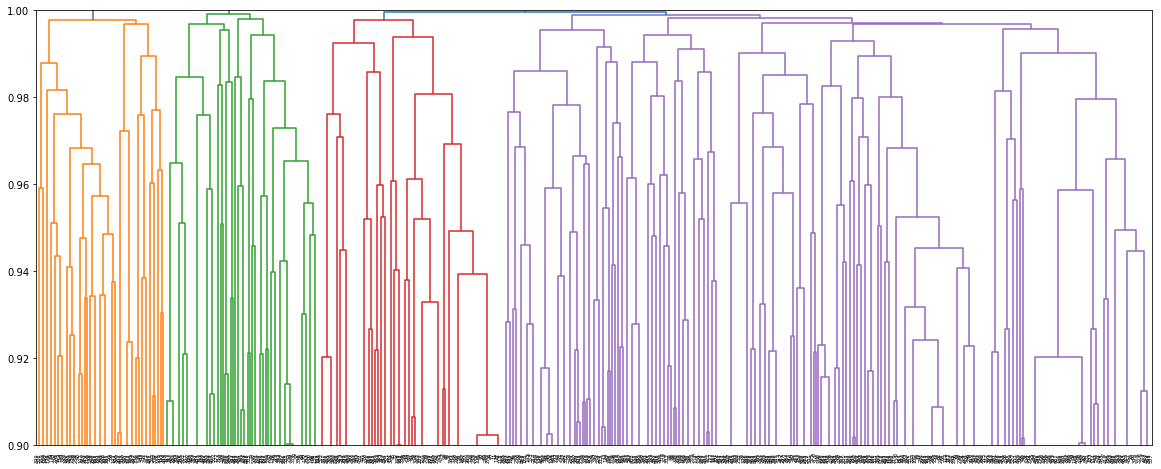

In [182]:
fig, axes = plt.subplots(1, 1, figsize=(20, 8))
linkage_matrix = get_linkage(best_params["dist_matrix"], best_params["method"], best_params["metric"])
dendrogram(linkage_matrix, color_threshold=linkage_matrix[-(4-1),2])
cluster_id = fcluster(linkage_matrix, best_params["K"], criterion="maxclust")    
print(evaluate_MV_cluster_id(train_matrix, valid_data, cluster_id))
plt.ylim(0.9,1)
plt.savefig("dendrogram.png")
plt.show()

In [121]:
cluster_id_h = cluster_id
cluster_id_h

array([4, 4, 3, 4, 4, 4, 4, 4, 4, 2, 4, 3, 4, 4, 4, 4, 1, 4, 4, 4, 2, 4,
       1, 2, 3, 4, 3, 3, 4, 4, 1, 4, 3, 4, 4, 4, 4, 2, 3, 4, 1, 3, 4, 3,
       3, 3, 4, 3, 4, 1, 2, 4, 4, 3, 3, 4, 1, 3, 4, 3, 4, 4, 1, 4, 1, 3,
       4, 4, 4, 4, 4, 4, 3, 3, 2, 3, 4, 3, 4, 2, 4, 1, 4, 1, 4, 4, 4, 4,
       4, 3, 4, 3, 2, 4, 2, 2, 2, 4, 4, 3, 2, 4, 1, 4, 4, 1, 3, 4, 2, 1,
       3, 3, 3, 1, 4, 4, 3, 2, 3, 4, 1, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 3,
       4, 4, 2, 2, 4, 4, 4, 4, 4, 4, 2, 3, 4, 4, 3, 4, 3, 1, 2, 4, 4, 4,
       1, 3, 4, 3, 2, 1, 4, 1, 4, 4, 1, 1, 4, 2, 4, 1, 4, 2, 2, 1, 1, 4,
       2, 2, 4, 1, 4, 2, 4, 3, 4, 1, 4, 4, 1, 1, 4, 2, 4, 1, 4, 3, 4, 2,
       2, 4, 4, 3, 4, 4, 4, 4, 4, 2, 2, 4, 1, 4, 1, 2, 4, 2, 4, 3, 1, 4,
       2, 1, 3, 4, 2, 1, 4, 4, 3, 4, 4, 4, 4, 2, 3, 4, 2, 3, 4, 4, 4, 4,
       4, 3, 1, 4, 4, 4, 4, 2, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 3, 2, 4,
       4, 4, 4, 4, 4, 3, 4, 4, 2, 4, 4, 4, 4, 1, 1, 3, 4, 1, 4, 3, 1, 4,
       2, 4, 3, 4, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4,

In [122]:
from scipy.cluster.hierarchy import leaves_list
ordered_students = leaves_list(linkage_matrix)

### K-means

In [32]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [33]:
df_all = pd.DataFrame(train_matrix.toarray())
df_all[df_all == 0] = -1
df_all = df_all.fillna(0)

2
12
22
32
42
52
62
72
82
92
102
112
122
132
142
152
162
172
182
192
202
212
222
232
242
252
262
272
282
292
302
312
322
332
342
352
362
372
382
392


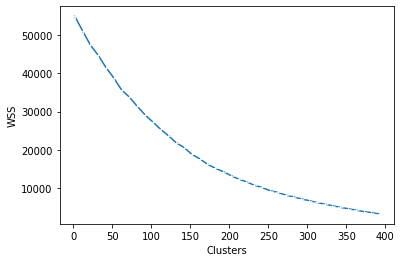

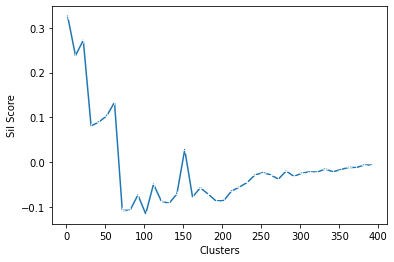

In [489]:
K = range(2,401,10)
wss = []
sil_score = []
for k in K:
    print(k)
    k_means=KMeans(n_clusters=k,random_state = SEED)
    k_means=k_means.fit(df_all)
    wss_iter = k_means.inertia_
    wss.append(wss_iter)
    score = silhouette_score(df_all,k_means.labels_)#,metric="euclidean",sample_size=1000,random_state=200)
    sil_score.append(score)
    
    
mycenters = pd.DataFrame({'Clusters' : K, 'WSS' : wss})
sns.lineplot(x = 'Clusters', y = 'WSS', data = mycenters, marker="+")
plt.show()

sil_centers = pd.DataFrame({'Clusters' : K, 'Sil Score' : sil_score})
sns.lineplot(x = 'Clusters', y = 'Sil Score', data = sil_centers, marker="+")
plt.show()

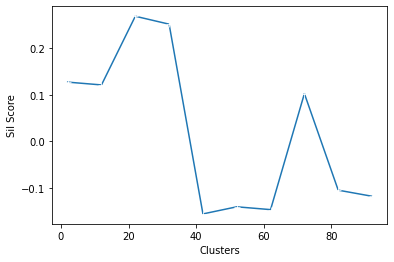

In [473]:
sil_centers = pd.DataFrame({'Clusters' : K, 'Sil Score' : sil_score})
sns.lineplot(x = 'Clusters', y = 'Sil Score', data = sil_centers.iloc[:10], marker="+")
plt.show()

#### Grid search

1
2
3
4
5
6
7
8
9
10


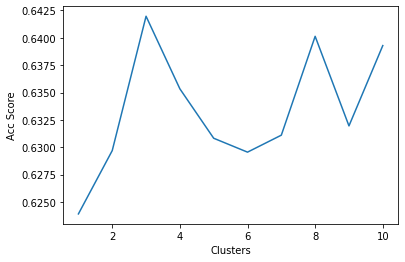

In [40]:
K = range(1,11,1)
acc_k_means = []
cl_ids = []

df_all = pd.DataFrame(train_matrix.toarray())
df_all[df_all == 0] = -1
df_all = df_all.fillna(0)

for k in K:
    print(k)
    k_means = KMeans(n_clusters = k, random_state = SEED, n_init = 100)
    
    k_means = k_means.fit(df_all)
    acc_k_means.append(evaluate_MV_cluster_id(train_matrix, valid_data, k_means.labels_))
    cl_ids.append(k_means.labels_)
    
acc_score = pd.DataFrame({'Clusters' : K, 'Acc Score' : acc_k_means})
sns.lineplot(x = 'Clusters', y = 'Acc Score', data = acc_score)
plt.show()

In [41]:
acc_score.sort_values("Acc Score")

,Clusters,Acc Score
0,1,0.623906
5,6,0.629551
1,2,0.629692
4,5,0.630821
6,7,0.631104
8,9,0.631950
3,4,0.635337
9,10,0.639289
7,8,0.640135
2,3,0.641970


In [44]:
k_means = KMeans(n_clusters = 3, random_state = SEED, n_init = 100)
cluster_id_k = k_means.fit_predict(df_all)
cluster_id_k = cluster_id_k+1
print(np.unique(cluster_id_k, return_counts=True))
cluster_id_k

(array([1, 2, 3], dtype=int32), array([492,  26,  24]))


array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 3, 1, 3,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 2, 1, 2, 3, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1,
       1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 2, 1, 1, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 3,

### Spectral

In [45]:
from sklearn.cluster import SpectralClustering
from sklearn.model_selection import ParameterSampler
from scipy.stats.distributions import randint, uniform
import time

K = range(1,11,1)

param_grid_rbf = {'n_clusters': K, 
                  'n_components': [None],#randint(1,50), 
                  'gamma': uniform(), 
                  'affinity': ["rbf"]}

param_grid_nn = {'n_clusters': K, 
                 'n_components': [None],#randint(1,50), 
                 'n_neighbors': randint(10,100), 
                 'affinity': ["nearest_neighbors"]}

list(ParameterSampler(param_grid_rbf, n_iter = 2, random_state=SEED))

[{'affinity': 'rbf',
  'gamma': 0.3745401188473625,
  'n_clusters': 8,
  'n_components': None},
 {'affinity': 'rbf',
  'gamma': 0.5986584841970366,
  'n_clusters': 7,
  'n_components': None}]

In [46]:
sc = SpectralClustering(n_init = 100, assign_labels = "cluster_qr", random_state = SEED, n_jobs = -1)
df_all = pd.DataFrame(train_matrix.toarray())
df_all[df_all == 0] = -1
df_all = df_all.fillna(0)

acc_sc = []
cl_ids_sc = []
params_rbf = ParameterSampler(param_grid_rbf, n_iter = 50, random_state=SEED)
for i,params in enumerate(params_rbf):
    s = time.time()
    sc = sc.set_params(**params)
    sc = sc.fit(df_all)
    acc_sc.append(evaluate_MV_cluster_id(train_matrix, valid_data, sc.labels_))
    cl_ids_sc.append(sc.labels_)
    print(i, "iteration completed. Accuracy:", acc_sc[-1], "Time(min):", (time.time() - s)/60)
    
params_nn = ParameterSampler(param_grid_nn, n_iter = 50, random_state=SEED)
for i,params in enumerate(params_nn):
    s = time.time()
    sc = sc.set_params(**params)
    sc = sc.fit(df_all)
    acc_sc.append(evaluate_MV_cluster_id(train_matrix, valid_data, sc.labels_))
    cl_ids_sc.append(sc.labels_)
    print(i, "iteration completed. Accuracy:", acc_sc[-1], "Time(min):", (time.time() - s)/60)

0 iteration completed. Accuracy: 0.5900366920688682 Time(min): 0.038568274180094404
1 iteration completed. Accuracy: 0.602314422805532 Time(min): 0.03711825211842855
2 iteration completed. Accuracy: 0.5982218458933107 Time(min): 0.038681467374165855
3 iteration completed. Accuracy: 0.6017499294383291 Time(min): 0.03857476313908895
4 iteration completed. Accuracy: 0.5976573525261079 Time(min): 0.04144193728764852
5 iteration completed. Accuracy: 0.6082416031611628 Time(min): 0.027873690923055014
6 iteration completed. Accuracy: 0.6014676827547276 Time(min): 0.04023828109105428
7 iteration completed. Accuracy: 0.6081004798193621 Time(min): 0.03067358732223511
8 iteration completed. Accuracy: 0.6298334744566751 Time(min): 0.032795576254526775
9 iteration completed. Accuracy: 0.5925769122212814 Time(min): 0.057622917493184406
10 iteration completed. Accuracy: 0.5970928591589049 Time(min): 0.049403866132100425
11 iteration completed. Accuracy: 0.5908834321196726 Time(min): 0.052693017323811

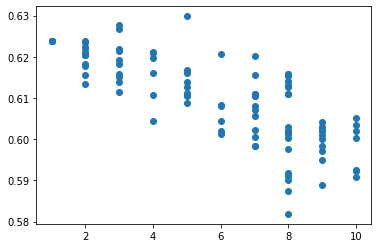

In [47]:
n_cl_list = [params["n_clusters"] for params in list(params_rbf) + list(params_nn)]
plt.scatter(n_cl_list, acc_sc)

In [48]:
np.argmax(acc_sc), list(params_rbf)[8]

(8,
 {'affinity': 'rbf',
  'gamma': 0.0007787658410143283,
  'n_clusters': 5,
  'n_components': None})

In [49]:
sc = SpectralClustering(n_init = 100, assign_labels = "cluster_qr", random_state = SEED, n_jobs = -1)
best_params = {'affinity': 'rbf',
  'gamma': 0.0007787658410143283,
  'n_clusters': 5,
  'n_components': None}
sc = sc.set_params(**best_params)
sc = sc.fit(df_all)
evaluate_MV_cluster_id(train_matrix, valid_data, sc.labels_)

0.6298334744566751

In [50]:
cluster_id_s = sc.labels_
cluster_id_s = cluster_id_s+1
cluster_id_s

array([3, 5, 4, 4, 5, 5, 2, 5, 5, 2, 5, 4, 2, 5, 5, 5, 5, 5, 2, 2, 5, 1,
       5, 2, 4, 1, 4, 4, 1, 5, 3, 1, 4, 5, 5, 5, 2, 2, 4, 1, 3, 4, 5, 5,
       4, 5, 2, 4, 3, 3, 2, 3, 5, 5, 4, 3, 3, 4, 4, 4, 1, 2, 5, 5, 3, 4,
       2, 5, 3, 5, 2, 5, 4, 4, 5, 4, 5, 4, 1, 3, 5, 3, 5, 3, 5, 5, 1, 5,
       2, 4, 4, 5, 5, 3, 5, 3, 2, 1, 5, 4, 3, 2, 3, 5, 1, 3, 4, 5, 5, 5,
       4, 1, 5, 3, 2, 5, 4, 5, 4, 5, 3, 5, 5, 2, 5, 5, 4, 4, 5, 2, 5, 4,
       5, 5, 3, 4, 1, 4, 1, 5, 5, 5, 5, 4, 2, 5, 4, 5, 4, 3, 3, 2, 3, 3,
       3, 4, 1, 1, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 3, 3, 5, 5, 3, 3, 3, 5,
       5, 5, 2, 5, 2, 5, 5, 5, 5, 2, 1, 5, 3, 2, 1, 3, 5, 5, 5, 5, 1, 3,
       3, 5, 5, 4, 5, 5, 3, 5, 5, 3, 5, 5, 3, 2, 3, 3, 5, 5, 2, 5, 3, 5,
       5, 3, 4, 3, 5, 3, 3, 5, 4, 5, 4, 2, 5, 3, 4, 5, 3, 4, 5, 5, 3, 5,
       5, 4, 3, 5, 2, 5, 5, 5, 3, 1, 5, 5, 1, 1, 3, 3, 3, 2, 1, 5, 2, 2,
       1, 5, 5, 5, 3, 4, 1, 3, 5, 5, 3, 2, 5, 5, 3, 4, 5, 3, 4, 4, 3, 4,
       5, 5, 5, 5, 1, 2, 2, 4, 1, 2, 1, 1, 5, 3, 2,

([3, 5, 4, 4, 5, 5, 2, 5, 5, 2, 5, 4, 2, 5, 5, 5, 5, 5, 2, 2, 5, 1,
       5, 2, 4, 1, 4, 4, 1, 5, 3, 1, 4, 5, 5, 5, 2, 2, 4, 1, 3, 4, 5, 5,
       4, 5, 2, 4, 3, 3, 2, 3, 5, 5, 4, 3, 3, 4, 4, 4, 1, 2, 5, 5, 3, 4,
       2, 5, 3, 5, 2, 5, 4, 4, 5, 4, 5, 4, 1, 3, 5, 3, 5, 3, 5, 5, 1, 5,
       2, 4, 4, 5, 5, 3, 5, 3, 2, 1, 5, 4, 3, 2, 3, 5, 1, 3, 4, 5, 5, 5,
       4, 1, 5, 3, 2, 5, 4, 5, 4, 5, 3, 5, 5, 2, 5, 5, 4, 4, 5, 2, 5, 4,
       5, 5, 3, 4, 1, 4, 1, 5, 5, 5, 5, 4, 2, 5, 4, 5, 4, 3, 3, 2, 3, 3,
       3, 4, 1, 1, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 3, 3, 5, 5, 3, 3, 3, 5,
       5, 5, 2, 5, 2, 5, 5, 5, 5, 2, 1, 5, 3, 2, 1, 3, 5, 5, 5, 5, 1, 3,
       3, 5, 5, 4, 5, 5, 3, 5, 5, 3, 5, 5, 3, 2, 3, 3, 5, 5, 2, 5, 3, 5,
       5, 3, 4, 3, 5, 3, 3, 5, 4, 5, 4, 2, 5, 3, 4, 5, 3, 4, 5, 5, 3, 5,
       5, 4, 3, 5, 2, 5, 5, 5, 3, 1, 5, 5, 1, 1, 3, 3, 3, 2, 1, 5, 2, 2,
       1, 5, 5, 5, 3, 4, 1, 3, 5, 5, 3, 2, 5, 5, 3, 4, 5, 3, 4, 4, 3, 4,
       5, 5, 5, 5, 1, 2, 2, 4, 1, 2, 1, 1, 5, 3, 2, 2, 5, 3, 4, 2, 5, 5,
       3, 5, 5, 2, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5,
       2, 5, 3, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 5, 3, 5, 4, 3,
       1, 5, 2, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 5, 5, 5, 5, 3,
       3, 5, 5, 5, 5, 5, 1, 5, 4, 5, 5, 5, 4, 5, 5, 5, 5, 1, 5, 5, 5, 3,
       5, 1, 5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 5, 4, 2, 5, 5, 5, 4, 3, 5, 5,
       5, 4, 5, 5, 5, 5, 5, 3, 5, 5, 5, 5, 1, 5, 5, 1, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 1, 5, 5, 5, 1, 5, 5, 5, 4, 5, 5, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 1, 5, 5, 1, 5, 5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 1, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

### Gausian mixtures

In [51]:
from sklearn.mixture import GaussianMixture

df_all = pd.DataFrame(train_matrix.toarray())
df_all[df_all == 0] = -1
df_all = df_all.fillna(0)

K = range(1,11,1)

param_grid_gausian = {
    "n_components": K,
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

gau_mix = GaussianMixture(random_state=SEED)

acc_g = []
cl_ids_g = []

params_gausian = ParameterSampler(param_grid_gausian, n_iter = 50, random_state=SEED)
for i,params in enumerate(params_gausian):
    s = time.time()
    gau_mix = gau_mix.set_params(**params)
    gau_mix = gau_mix.fit(df_all)
    acc_g.append(evaluate_MV_cluster_id(train_matrix, valid_data, gau_mix.predict(df_all)))
    cl_ids_g.append(gau_mix.predict(df_all))
    print(i, "iteration completed. Accuracy:", acc_g[-1], "Time(min):", (time.time() - s)/60)

/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


0 iteration completed. Accuracy: 0.6239062941010444 Time(min): 0.010490930080413819
1 iteration completed. Accuracy: 0.6257408975444538 Time(min): 0.011399590969085693
2 iteration completed. Accuracy: 0.6285633643804686 Time(min): 0.009804224967956543
3 iteration completed. Accuracy: 0.6291278577476714 Time(min): 0.010642453034718832
4 iteration completed. Accuracy: 0.6145921535421959 Time(min): 0.015336314837137857
5 iteration completed. Accuracy: 0.6158622636184025 Time(min): 0.018580774466196697
6 iteration completed. Accuracy: 0.6169912503528083 Time(min): 0.018332183361053467
7 iteration completed. Accuracy: 0.6181202370872142 Time(min): 0.0195156733194987
8 iteration completed. Accuracy: 0.6178379904036128 Time(min): 0.016534499327341714
9 iteration completed. Accuracy: 0.6195314705052216 Time(min): 0.017433865865071615
10 iteration completed. Accuracy: 0.6239062941010444 Time(min): 0.042686490217844646
11 iteration completed. Accuracy: 0.6257408975444538 Time(min): 0.05060499111

In [57]:
n_min_cl = [np.unique(c, return_counts=True)[1].min() for c in cl_ids_g]
n_cl = [len(np.unique(c)) for c in cl_ids_g]
temp = pd.DataFrame({"n_min_cl":n_min_cl, "acc_g": acc_g, "n_cl": n_cl})
temp.sort_values("acc_g").iloc[-1]

n_min_cl    1.000000
acc_g       0.644369
n_cl        7.000000
Name: 36, dtype: float64

In [59]:
list(params_gausian)[36]

/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'n_components': 7, 'covariance_type': 'full'}

/home/nata/PycharmProjects/venv/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


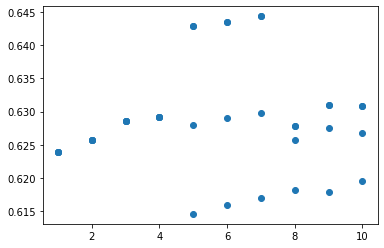

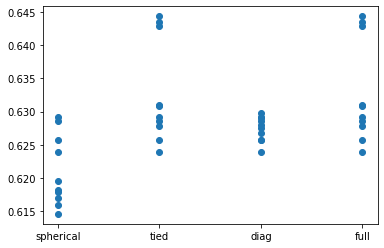

In [58]:
n_cl_list = [params["n_components"] for params in list(params_gausian)]
cov_list = [params["covariance_type"] for params in list(params_gausian)]
plt.scatter(n_cl_list, acc_g)
plt.show()
plt.scatter(cov_list, acc_g)
plt.show()

In [60]:
gau_mix = GaussianMixture(random_state=SEED)
best_params = {'n_components': 7, 'covariance_type': 'full'}
gau_mix = gau_mix.set_params(**best_params)
gau_mix = gau_mix.fit(df_all)
evaluate_MV_cluster_id(train_matrix, valid_data, gau_mix.predict(df_all))

0.6443691786621507

In [61]:
cluster_id_g = gau_mix.predict(df_all)
cluster_id_g = cluster_id_g+1
cluster_id_g

array([6, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 5, 2, 2, 2, 5, 2, 2, 2,
       3, 2, 2, 2, 2, 5, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 5, 2,
       2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 5, 2, 1, 2, 2, 5, 2, 2, 2, 2,
       2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2,
       2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 4, 2, 2,
       5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 5, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 5, 2, 5, 5, 2, 5, 2, 5, 2, 2, 2, 5,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 5, 2, 5, 5, 2, 2, 2, 2, 5, 2,
       2, 5, 2, 5, 5, 5, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2,
       2, 2, 5, 2, 2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 5, 7, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 5, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2, 2, 5, 2, 2, 5, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 5, 2,

## Analysis

In [123]:
cluster_id = cluster_id_h

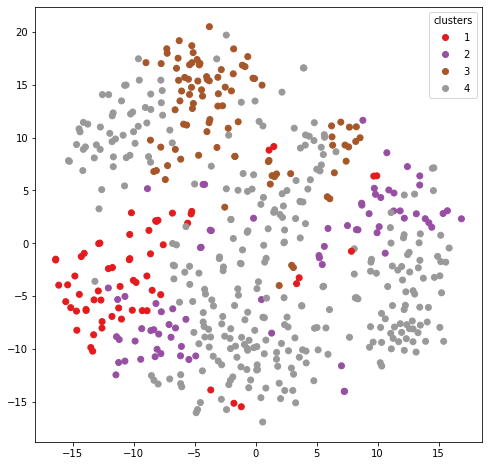

In [157]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

df_all = pd.DataFrame(train_matrix.toarray())
df_all[df_all == 0] = -1
df_all = df_all.fillna(0)

compotents = TSNE(2, perplexity = 60, random_state = SEED, metric = cosine).fit_transform(df_all)
fig, ax = plt.subplots(figsize = (8,8))
s = ax.scatter(compotents[:,0], compotents[:,1], c = cluster_id, cmap='Set1')
ax.legend(*s.legend_elements(), title='clusters')
plt.savefig("cluster_tsne.png")

In [124]:
np.unique(cluster_id, return_counts=True)

(array([1, 2, 3, 4], dtype=int32), array([ 62,  75,  90, 315]))

In [24]:
df_all = pd.DataFrame(train_data)

In [25]:
print("unique questions =", df_all.question_id.nunique())
print("unique users =", df_all.user_id.nunique())

unique questions = 1774
unique users = 542


In [26]:
question_meta = pd.read_csv("starter_code/data/question_meta.csv")
question_meta = question_meta.set_index("question_id")
subject_meta = pd.read_csv("starter_code/data/subject_meta.csv")
subject_meta = subject_meta.set_index("subject_id")

def find_subjects(q_id):
    s_list = question_meta.loc[q_id].subject_id
    s_list = [int(i) for i in s_list[1:-1].split(',')]
    s_names = subject_meta.loc[s_list].name.to_list()
    return s_names
find_subjects(337)

['Maths', 'Number', 'Basic Arithmetic', 'Written Multiplication']

In [27]:
subject_df = []
for u, q, c in df_all.values:
    for s in find_subjects(q):
        subject_df.append([u,s,c])
subject_df = pd.DataFrame(subject_df, columns = ["user_id", "subject_id", "is_correct"])
subject_df

,user_id,subject_id,is_correct
0,488,Maths,1
1,488,Data and Statistics,1
2,488,Time Series and Line Graphs,1
3,488,Data Representation,1
4,355,Maths,1
...,...,...,...
236174,308,"Square Roots, Cube Roots, etc",0
236175,514,Maths,1
236176,514,Data and Statistics,1
236177,514,"Averages (mean, median, mode) from a List of Data",1


In [154]:
subject_df["cluster"] = subject_df.user_id.map(lambda x: cluster_id[x])
group_df = subject_df.groupby(["cluster", "subject_id", "is_correct"]).count()
for i in range(1,5):
    print(group_df.loc[i].sort_values("user_id", ascending = False).iloc[:20])

                                               user_id
subject_id                         is_correct         
Maths                              0              6055
                                   1              3499
Number                             0              2662
                                   1              1548
Geometry and Measure               0              1540
Algebra                            0              1341
Basic Arithmetic                   0               916
Geometry and Measure               1               879
Algebra                            1               792
Basic Arithmetic                   1               511
Data and Statistics                0               508
Fractions                          0               389
Angles                             0               320
Solving Equations                  0               306
Data and Statistics                1               305
Data Representation                0               295
Mental Mul

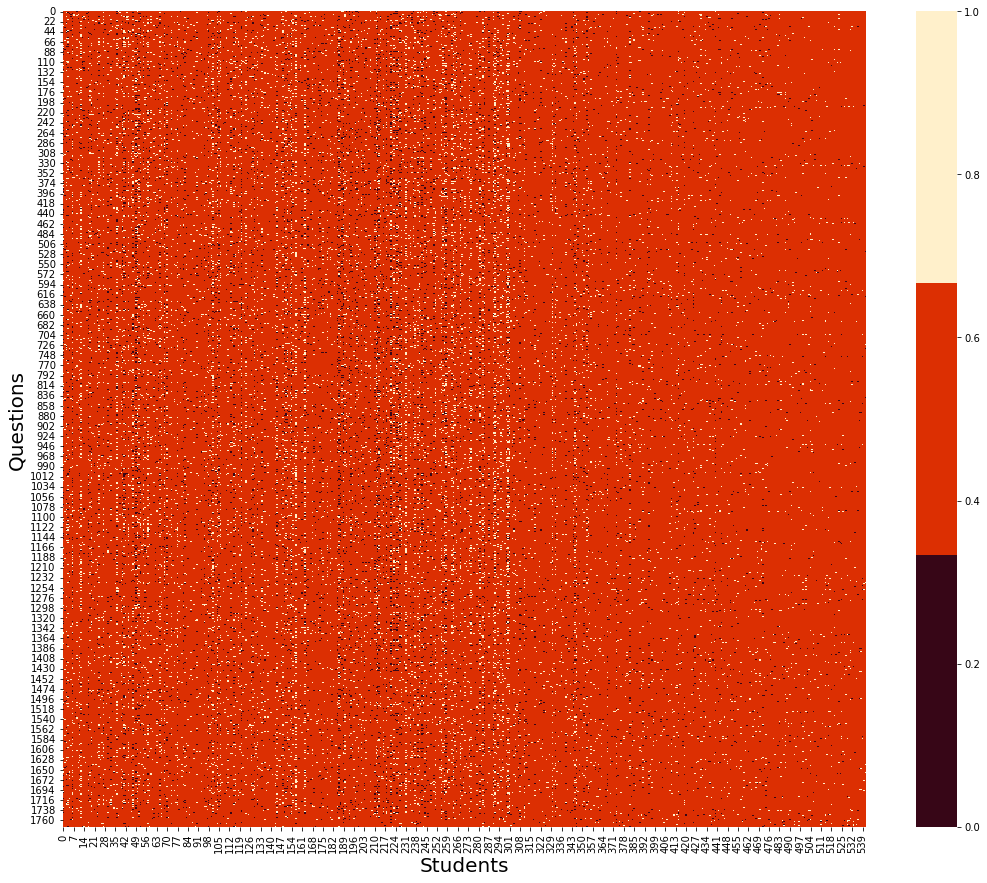

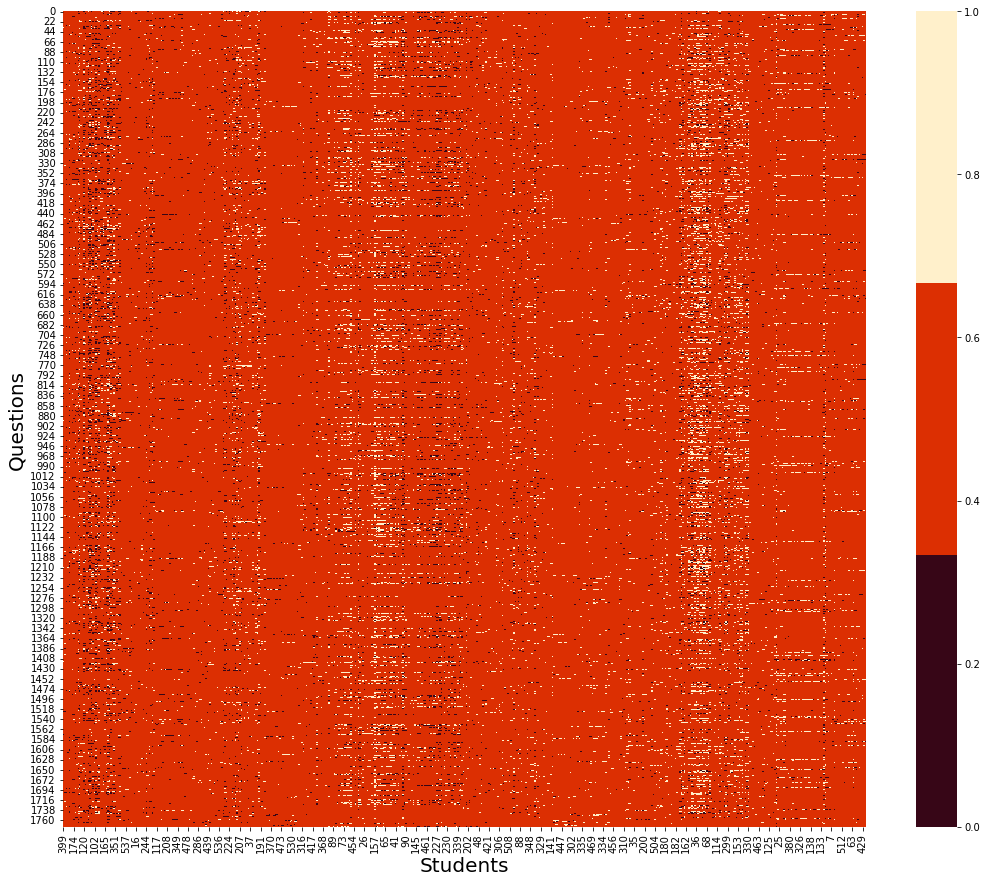

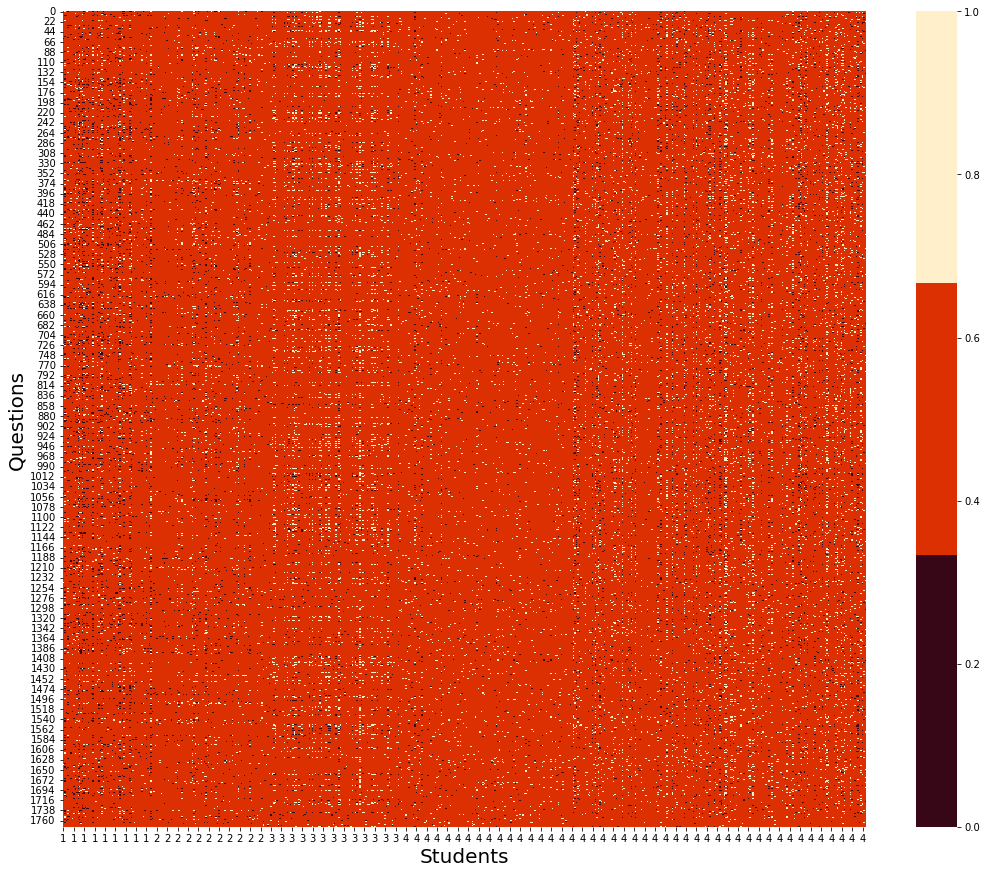

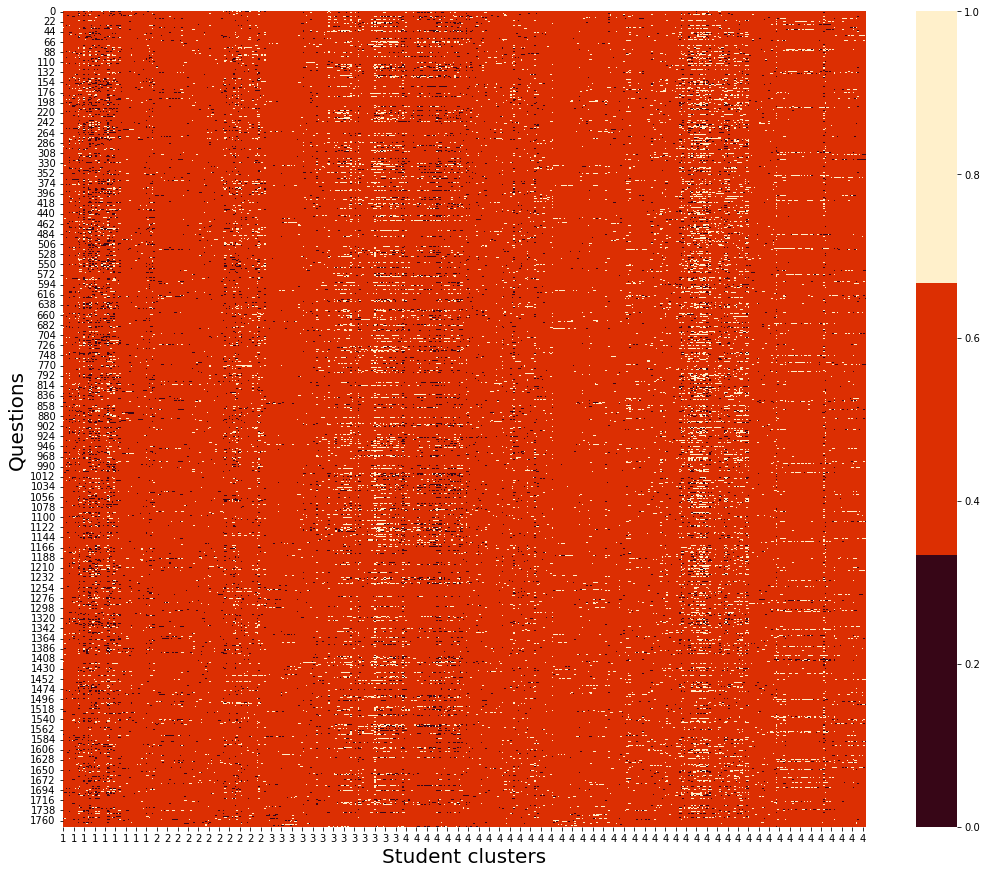

In [160]:
colors = ["#370617","#dc2f02", "#FFF0CB"]# Set your custom color palette
cmap = sns.color_palette(colors)

matrix_plot = pd.DataFrame(train_matrix.toarray()).fillna(0.5)

plt.figure(figsize = (18,15))
sns.heatmap(matrix_plot.transpose(), cmap=cmap)
plt.xlabel("Students", fontsize = 20)
plt.ylabel("Questions", fontsize = 20)
plt.show()

plt.figure(figsize = (18,15))
sns.heatmap(matrix_plot.iloc[ordered_students].transpose(), cmap=cmap)
plt.xlabel("Students", fontsize = 20)
plt.ylabel("Questions", fontsize = 20)
plt.show()

matrix_plot = pd.DataFrame(train_matrix.toarray(), index = cluster_id).fillna(0.5)

plt.figure(figsize = (18,15))
sns.heatmap(matrix_plot.sort_index().transpose(), cmap=cmap)
plt.xlabel("Students", fontsize = 20)
plt.ylabel("Questions", fontsize = 20)
plt.show()

plt.figure(figsize = (18,15))
sns.heatmap(matrix_plot.iloc[ordered_students].transpose(), cmap=cmap)
plt.xlabel("Student clusters", fontsize = 20)
plt.ylabel("Questions", fontsize = 20)
plt.savefig("heatmap.png")
plt.show()

### Success rate of questions in clusters

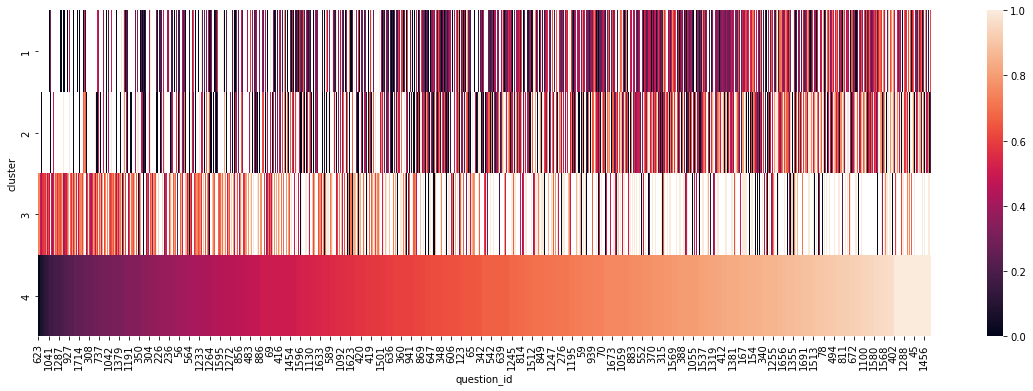

In [128]:
df_all["cluster"] = df_all.user_id.map(lambda x: cluster_id[x])

cl_q_group2 = df_all.groupby(["cluster", "question_id"])["is_correct"].count().reset_index()
cl_q_group2 = cl_q_group2.pivot(index = "question_id", columns = "cluster", values = "is_correct")

cl_q_group = df_all.groupby(["cluster", "question_id"])["is_correct"].sum().reset_index()
cl_q_group = cl_q_group.pivot(index = "question_id", columns = "cluster", values = "is_correct")
cl_q_group = cl_q_group/cl_q_group2

plt.figure(figsize = (20,6))
sns.heatmap(cl_q_group.sort_values(4).transpose())
plt.show()

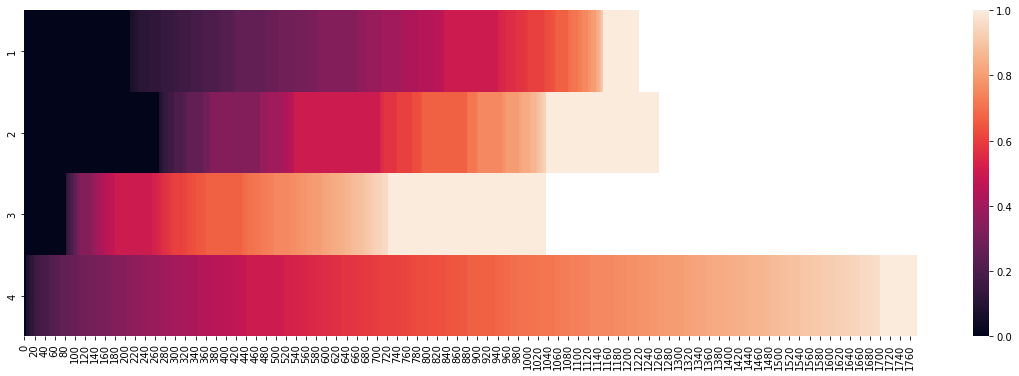

In [129]:
cl_q_group_sorted = pd.concat([cl_q_group.sort_values(i)[i].reset_index(drop = True) for i in range(1,np.max(cluster_id)+1)], axis = 1)
plt.figure(figsize = (20,6))
sns.heatmap(cl_q_group_sorted.transpose())
plt.show()

In [239]:
good_s = []
bad_s = []
good_q = []
bad_q = []
for q in cl_q_group[cl_q_group[1] >= 0.5].index:
    good_s = good_s + find_subjects(q)
    good_q.append(q)
for q in cl_q_group[cl_q_group[1] < 0.5].index:
    bad_s = bad_s + find_subjects(q)
    bad_q.append(q)
len(good_s), len(bad_s), len(good_q), len(bad_q)

(461, 4686, 112, 1123)

In [244]:
cl_q_group[cl_q_group.index.isin(bad_q)][1].mean(), cl_q_group[cl_q_group.index.isin(good_q)][1].mean()

(0.0956839176401225, 0.7986068917271358)

In [238]:
print(df_all[(df_all["cluster"] == 1)&(df_all["question_id"].isin(good_q))].is_correct.mean())
pd.Series(good_s).value_counts().iloc[:10]/len(good_s)

0.7656370656370657


Maths                                 0.242950
Number                                0.108460
Geometry and Measure                  0.071584
Algebra                               0.043384
Basic Arithmetic                      0.034707
Data and Statistics                   0.021692
Fractions                             0.021692
Mental Multiplication and Division    0.015184
Perimeter and Area                    0.015184
Data Representation                   0.013015
dtype: float64

In [240]:
print(df_all[(df_all["cluster"] == 1)&(df_all["question_id"].isin(bad_q))].is_correct.mean())
pd.Series(bad_s).value_counts().iloc[:10]/len(bad_s)

0.7354497354497355


Maths                   0.239650
Number                  0.107341
Geometry and Measure    0.061886
Algebra                 0.049936
Basic Arithmetic        0.035425
Data and Statistics     0.020913
Fractions               0.015365
Angles                  0.013017
Data Representation     0.011097
Solving Equations       0.010030
dtype: float64

In [229]:
df_all[df_all["cluster"] == 1].is_correct.mean()

0.7484979973297731

In [234]:
mental_q = []
for q in cl_q_group.index:
    if "Mental Multiplication and Division" in find_subjects(q):
        mental_q.append(q)
mental_q
df_all[(df_all["cluster"] == 1)&(df_all["question_id"].isin(mental_q))].is_correct.mean()

0.75

In [109]:
good_s = []
bad_s = []
for q in cl_q_group[cl_q_group[4] > 0.0005].index:
    good_s = good_s + find_subjects(q)
for q in cl_q_group[cl_q_group[4] < 0.0005].index:
    bad_s = bad_s + find_subjects(q)
len(good_s), len(bad_s)

(2073, 1827)

In [102]:
pd.Series(good_s).value_counts().iloc[:10]/len(good_s)

Maths                            0.241196
Number                           0.109986
Geometry and Measure             0.056440
Algebra                          0.050169
Basic Arithmetic                 0.034732
Data and Statistics              0.023155
Factors, Multiples and Primes    0.014472
Fractions                        0.013989
Angles                           0.012060
Rounding and Estimating          0.011095
dtype: float64

In [103]:
pd.Series(bad_s).value_counts().iloc[:10]/len(bad_s)

Maths                   0.241379
Number                  0.108374
Geometry and Measure    0.061850
Algebra                 0.048714
Basic Arithmetic        0.039409
Data and Statistics     0.023536
Data Representation     0.013684
Fractions               0.013136
Solving Equations       0.012589
Angles                  0.012042
dtype: float64

### General statistics

In [130]:
clusters_df = pd.DataFrame(train_matrix.toarray(), index = cluster_id)
clusters_df.index.name = "cluster"
print("Number of correct answers per cluster:")
clusters_df.groupby("cluster").sum().sum(axis = 1)

Number of correct answers per cluster:


cluster
1     3499.0
2     2913.0
3     6958.0
4    20554.0
dtype: float64

In [131]:
print("Number of correct answers per one person:")
clusters_df.groupby("cluster").sum().sum(axis = 1)/clusters_df.index.value_counts()

Number of correct answers per one person:


1    56.435484
2    38.840000
3    77.311111
4    65.250794
dtype: float64

In [132]:
print("Number of any answers per cluster:")
clusters_df.groupby("cluster").count().sum(axis = 1)

Number of any answers per cluster:


cluster
1     9554
2     5504
3     9942
4    31688
dtype: int64

In [133]:
print("Number of any answers per one person:")
clusters_df.groupby("cluster").count().sum(axis = 1)/clusters_df.index.value_counts()

Number of any answers per one person:


1    154.096774
2     73.386667
3    110.466667
4    100.596825
dtype: float64

In [189]:
clusters_df.count(axis = 1).sort_values().groupby("cluster").median()

cluster
1    113
2     42
3     53
4     56
dtype: int64

In [134]:
clusters_df.mean(axis = 1).groupby("cluster").mean()

cluster
1    0.379716
2    0.512399
3    0.644171
4    0.677344
dtype: float64

In [135]:
clusters_df.mean(axis = 1).groupby("cluster").std()

cluster
1    0.131703
2    0.188476
3    0.176247
4    0.189796
dtype: float64

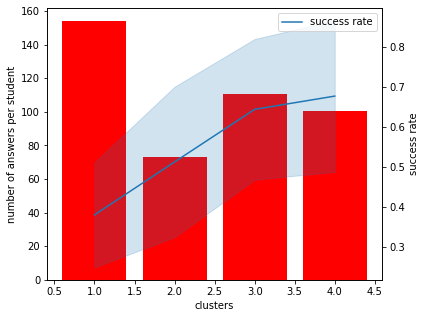

In [181]:
df_plot = clusters_df.mean(axis = 1).reset_index()
df_plot.columns = ["cluster", "success rate"]
f, ax = plt.subplots(figsize = (6,5))
ax.bar(range(1,5), clusters_df.groupby("cluster").count().sum(axis = 1)/clusters_df.index.value_counts(), color = "r", label = "number of answers")
ax.set_ylabel("number of answers per student")
ax2 = ax.twinx()

sns.lineplot(data = df_plot, x = 'cluster', y = "success rate", errorbar='sd', ax = ax2, label = "success rate")#('ci', 99))
ax2.set_xlabel("clusters")
ax.set_xlabel("clusters")
plt.legend()
plt.savefig("stats.png")

<ipython-input-164-ba3557e7833f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clusters_df.loc[cl].mean(axis = 1), label = cl, hist = False)
<ipython-input-164-ba3557e7833f>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(clusters_df.loc[cl].mean(axis = 1), label = cl, hist

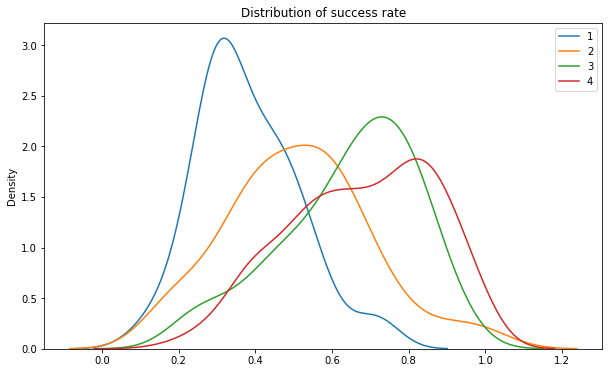

In [164]:
plt.figure(figsize = (10,6))
for cl in sorted(clusters_df.index.unique()):
    sns.distplot(clusters_df.loc[cl].mean(axis = 1), label = cl, hist = False)
plt.legend()
plt.title("Distribution of success rate")
plt.savefig("dist.png")
plt.show()

In [138]:
clusters_df.index.value_counts()

4    315
3     90
2     75
1     62
Name: cluster, dtype: int64

In [139]:
df_all.groupby("cluster").count()

,user_id,question_id,is_correct
cluster,,,
1,9554,9554,9554
2,5504,5504,5504
3,9942,9942,9942
4,31688,31688,31688


In [105]:
student_meta = pd.read_csv("starter_code/data/student_meta.csv")
student_meta["data_of_birth"] = pd.to_datetime(student_meta.data_of_birth)
student_meta_df_all = df_all[["user_id", "cluster"]].drop_duplicates().merge(student_meta, left_on = "user_id", right_on = "user_id")
student_meta_df_all["year"] = student_meta_df_all.data_of_birth.dt.year
student_meta_df_all.groupby("cluster").mean()

,user_id,gender,premium_pupil,year
cluster,,,,
1,244.241935,1.048387,0.333333,2005.840909
2,280.480000,1.226667,0.230769,2005.433962
3,252.377778,1.188889,0.300000,2005.983051
4,278.469841,1.165079,0.189474,2005.469194


In [106]:
student_meta_df_all.groupby("cluster").std()

,user_id,gender,premium_pupil,year
cluster,,,,
1,146.495531,0.687772,0.485071,2.281811
2,152.464560,0.781083,0.429669,3.840620
3,168.732457,0.762822,0.466092,3.020000
4,155.630467,0.743155,0.393963,2.963709


In [113]:
subject_df["cluster"] = subject_df.user_id.map(lambda x: cluster_id[x])
subject_df.groupby("cluster").mean()

,user_id,is_correct
cluster,,
1,253.330321,0.747841
2,176.036582,0.721321
3,194.289594,0.475437
4,151.971444,0.684669
5,275.684649,0.519555


In [118]:
subject_df["cluster"] = subject_df.user_id.map(lambda x: cluster_id[x])
subject_df[subject_df.subject_id!="Mental Multiplication and Division"].groupby("cluster").mean()

,user_id,is_correct
cluster,,
1,253.314469,0.747815
2,176.016693,0.721254
3,194.263918,0.475263
4,151.938998,0.684150
5,275.638203,0.519460


Spectral clustering interpretation:


- 1 - "struggling" - students who does lots of questions, but most of them are incorrect
- 2 - "random/inactive" - students who did the least questions, and the success rate is almost random
- 3 - "good students" - good success rate and lots of questions are done
- 4 - "best performers" - the highest success rate

## Evaluation

https://www.kaggle.com/competitions/csc311-fall-2022/leaderboard

In [103]:
clusters_df = pd.DataFrame(train_matrix.toarray(), index = cluster_id)
filled_matrix = clusters_df.copy()
for i in clusters_df.index.unique():
    filled_matrix.loc[i] = clusters_df.loc[i].fillna(clusters_df.loc[i].mean(axis = 0))
filled_matrix

,0,1,2,3,4,5,6,7,8,9,...,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773
4,NaN,NaN,0.437500,0.550000,0.200,0.0,0.666667,0.000000,0.666667,NaN,...,0.714286,0.25,0.666667,0.200000,0.666667,0.857143,0.333333,1.0,0.6,0.294118
5,0.750000,0.0,0.000000,1.000000,0.300,0.6,0.888889,0.894737,0.666667,0.692308,...,1.000000,NaN,1.000000,0.666667,NaN,NaN,1.000000,NaN,NaN,0.000000
3,1.000000,NaN,1.000000,0.882353,NaN,NaN,NaN,NaN,1.000000,1.000000,...,NaN,0.90,0.500000,0.600000,1.000000,0.000000,1.000000,0.0,1.0,0.900000
4,NaN,NaN,0.000000,1.000000,0.200,0.0,0.666667,0.000000,0.666667,NaN,...,0.714286,0.25,0.666667,0.200000,0.666667,0.857143,0.333333,1.0,0.6,0.000000
4,NaN,NaN,0.437500,0.550000,0.000,0.0,0.666667,0.000000,0.666667,NaN,...,0.714286,0.25,0.666667,0.200000,0.666667,0.857143,0.333333,1.0,0.6,0.294118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,0.285714,0.6,NaN,NaN,0.125,0.0,0.285714,0.333333,0.000000,NaN,...,0.142857,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.437500,0.550000,0.200,0.0,0.666667,0.000000,0.666667,NaN,...,0.714286,0.25,0.666667,0.200000,0.666667,0.857143,0.333333,1.0,0.6,0.294118
3,1.000000,NaN,0.636364,0.882353,NaN,NaN,NaN,NaN,1.000000,1.000000,...,NaN,0.90,0.500000,0.600000,1.000000,0.000000,0.869565,0.0,1.0,0.900000
4,NaN,NaN,0.437500,0.550000,0.200,0.0,0.666667,0.000000,0.666667,NaN,...,0.714286,0.25,0.666667,0.200000,0.666667,0.857143,0.333333,1.0,0.6,0.294118


In [419]:
clusters_df = pd.DataFrame(train_matrix.toarray(), index = cluster_id)
filled_matrix = clusters_df.fillna(clusters_df.mean(axis = 0))
filled_matrix

,0,1,2,3,4,5,6,7,8,9,...,1764,1765,1766,1767,1768,1769,1770,1771,1772,1773
cluster,,,,,,,,,,,,,,,,,,,,,
4,0.424242,0.538462,0.5,0.710526,0.269231,0.409091,0.733333,0.7,0.375,0.689655,...,0.434783,0.545455,0.5625,0.521739,0.916667,0.6,0.735294,0.454545,0.714286,0.5
2,0.424242,0.000000,0.5,0.710526,0.269231,0.409091,0.733333,0.7,0.375,0.689655,...,0.434783,0.545455,0.5625,0.521739,0.916667,0.6,0.735294,0.454545,0.714286,0.5
4,0.424242,0.538462,1.0,0.710526,0.269231,0.409091,0.733333,0.7,0.375,0.689655,...,0.434783,0.545455,0.5625,0.521739,0.916667,0.6,1.000000,0.454545,0.714286,0.5
1,0.424242,0.538462,0.0,1.000000,0.269231,0.409091,0.733333,0.7,0.375,0.689655,...,0.434783,0.545455,0.5625,0.521739,0.916667,0.6,0.735294,0.454545,0.714286,0.0
1,0.424242,0.538462,0.5,0.710526,0.000000,0.409091,0.733333,0.7,0.375,0.689655,...,0.434783,0.545455,0.5625,0.521739,0.916667,0.6,0.735294,0.454545,0.714286,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,0.424242,0.538462,0.5,0.710526,0.269231,0.409091,0.733333,0.7,0.000,0.689655,...,0.434783,0.545455,0.5625,0.521739,0.916667,0.6,0.735294,0.454545,0.714286,0.5
4,0.424242,0.538462,0.5,0.710526,0.269231,0.409091,0.733333,0.7,0.375,0.689655,...,0.434783,0.545455,0.5625,0.521739,0.916667,0.6,0.735294,0.454545,0.714286,0.5
3,0.424242,0.538462,0.5,0.710526,0.269231,0.409091,0.733333,0.7,0.375,0.689655,...,0.434783,0.545455,0.5625,0.521739,0.916667,0.6,0.735294,0.454545,0.714286,0.5


In [108]:
evaluate_MV_cluster_id(train_matrix, valid_data, cluster_id)

0.6549534292972058

In [109]:
evaluate_MV_cluster_id(train_matrix, test_data, cluster_id)

0.6604572396274344

In [104]:
#print("Train acc:", sparse_matrix_evaluate(train_data, filled_matrix.values, threshold=0.5))
print("Valid acc:", sparse_matrix_evaluate(valid_data, filled_matrix.values, threshold=0.5))
print("Test  acc:", sparse_matrix_evaluate(test_data, filled_matrix.values, threshold=0.5))

Valid acc: 0.6531188258537962
Test  acc: 0.6550945526390065


**No clustering majority vote**:

- Train acc: 1.0
- Valid acc: 0.6239062941010444
- Test  acc: 0.6248941574936494


**Spectral**

- Valid acc: 0.6298334744566751
- Test  acc: 0.6375952582557155

**K-means**

- Valid acc: 0.6392887383573242
- Test  acc: 0.6311035845328817

**Gaussian**

- Valid acc: 0.6443691786621507
- Test  acc: 0.6398532317245272

**Hierarhical**

- Valid acc: 0.6549534292972058
- **Test  acc: 0.6604572396274344**